In [52]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
from glob import glob

file_path = "/Users/singhateh-julla/Desktop/Project/diabetes-anomaly-prediction/data"

def parse_glucose_xml(filepath):
    tree = ET.parse(filepath)
    root = tree.getroot()
    glucose_events = root.find("glucose_level")

    rows = []
    for event in glucose_events.findall("event"):
        ts = event.attrib.get("ts")
        value = event.attrib.get("value")
        if ts and value:
            rows.append({
                "timestamp": pd.to_datetime(ts, format="%d-%m-%Y %H:%M:%S"),
                "glucose": float(value)
            })

    df = pd.DataFrame(rows)
    df = df.set_index("timestamp").sort_index()
    return df

def convert_all_xml_to_csv(input_dir="data/", output_dir="models/"):
    os.makedirs(output_dir, exist_ok=True)
    xml_files = glob(os.path.join(input_dir, "*.xml")) + glob(os.path.join(input_dir, "*.XML"))

    if not xml_files:
        print("⚠️ No XML files found!")
        return

    print(f"🔍 Found {len(xml_files)} XML files")

    for filepath in xml_files:
        filename = os.path.basename(filepath).replace(".xml", "").replace(".XML", "")
        print(f"📂 Processing {filename}...")

        try:
            df = parse_glucose_xml(filepath)
            if df.empty:
                print(f"⚠️ Skipped {filename}: No valid glucose data")
                continue
            output_csv = os.path.join(output_dir, f"{filename}.csv")
            df.to_csv(output_csv)
            print(f"✅ Saved: {output_csv}")
        except Exception as e:
            print(f"❌ Error in {filename}: {e}")

# Run the conversion
convert_all_xml_to_csv("/Users/singhateh-julla/Desktop/Project/diabetes-anomaly-prediction/data", "./models/")


🔍 Found 12 XML files
📂 Processing 575-ws-training...
✅ Saved: ./models/575-ws-training.csv
📂 Processing 563-ws-training...
✅ Saved: ./models/563-ws-training.csv
📂 Processing 559-ws-testing...
✅ Saved: ./models/559-ws-testing.csv
📂 Processing 559-ws-training...
✅ Saved: ./models/559-ws-training.csv
📂 Processing 588-ws-testing...
✅ Saved: ./models/588-ws-testing.csv
📂 Processing 570-ws-testing...
✅ Saved: ./models/570-ws-testing.csv
📂 Processing 588-ws-training...
✅ Saved: ./models/588-ws-training.csv
📂 Processing 563-ws-testing...
✅ Saved: ./models/563-ws-testing.csv
📂 Processing 570-ws-training...
✅ Saved: ./models/570-ws-training.csv
📂 Processing 591-ws-training...
✅ Saved: ./models/591-ws-training.csv
📂 Processing 591-ws-testing...
✅ Saved: ./models/591-ws-testing.csv
📂 Processing 575-ws-testing...
✅ Saved: ./models/575-ws-testing.csv


✅ Loaded: (10796, 1)
✅ Resampled: (12081, 1)
✅ Cleaned data saved to ../models/559-ws-training_cleaned.csv


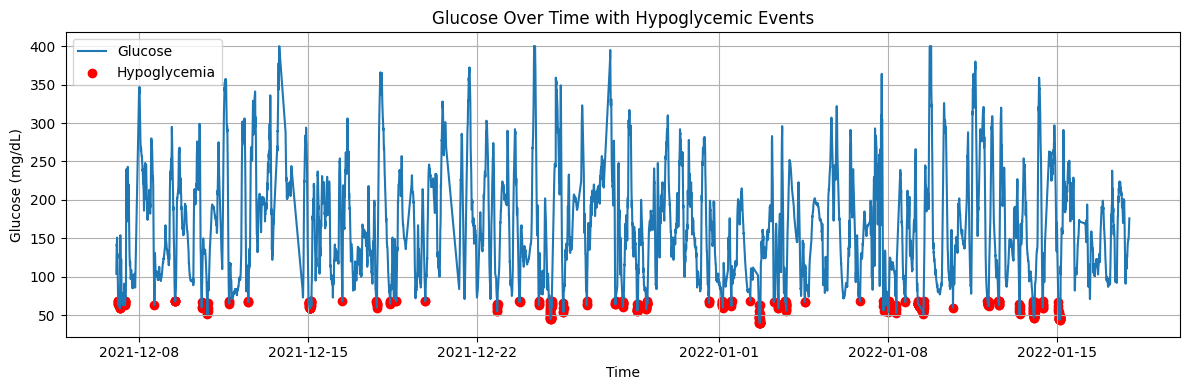

In [ ]:
# Step 1: Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import os

# Step 2: Load your file (change filename as needed)
file_path = "../notebooks/models/559-ws-training.csv"
df = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")
df = df.sort_index()
print("✅ Loaded:", df.shape)

# Step 3: Resample to 5-minute intervals and interpolate
df = df.resample("5min").mean()
df = df.interpolate()
print("✅ Resampled:", df.shape)

# Step 4: Feature Engineering
df["glucose_change"] = df["glucose"].diff()
df["glucose_rolling_mean"] = df["glucose"].rolling(window=3).mean()
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["hypo_event"] = (df["glucose"] < 70).astype(int)

df = df.dropna()

# Step 5: Save cleaned data
output_path = "../models/559-ws-training_cleaned.csv"
df.to_csv(output_path)
print(f"✅ Cleaned data saved to {output_path}")

# Step 6: Quick Plot
plt.figure(figsize=(12, 4))
plt.plot(df["glucose"], label="Glucose")
plt.scatter(df[df["hypo_event"] == 1].index, df[df["hypo_event"] == 1]["glucose"], color="red", label="Hypoglycemia")
plt.title("Glucose Over Time with Hypoglycemic Events")
plt.xlabel("Time")
plt.ylabel("Glucose (mg/dL)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


✅ Loaded: (12079, 6)
                     glucose  glucose_change  glucose_rolling_mean  hour  \
timestamp                                                                  
2021-12-07 01:25:00    104.0             6.0            101.000000     1   
2021-12-07 01:30:00    112.0             8.0            104.666667     1   
2021-12-07 01:35:00    120.0             8.0            112.000000     1   
2021-12-07 01:40:00    127.0             7.0            119.666667     1   
2021-12-07 01:45:00    135.0             8.0            127.333333     1   

                     dayofweek  hypo_event  
timestamp                                   
2021-12-07 01:25:00          1           0  
2021-12-07 01:30:00          1           0  
2021-12-07 01:35:00          1           0  
2021-12-07 01:40:00          1           0  
2021-12-07 01:45:00          1           0  


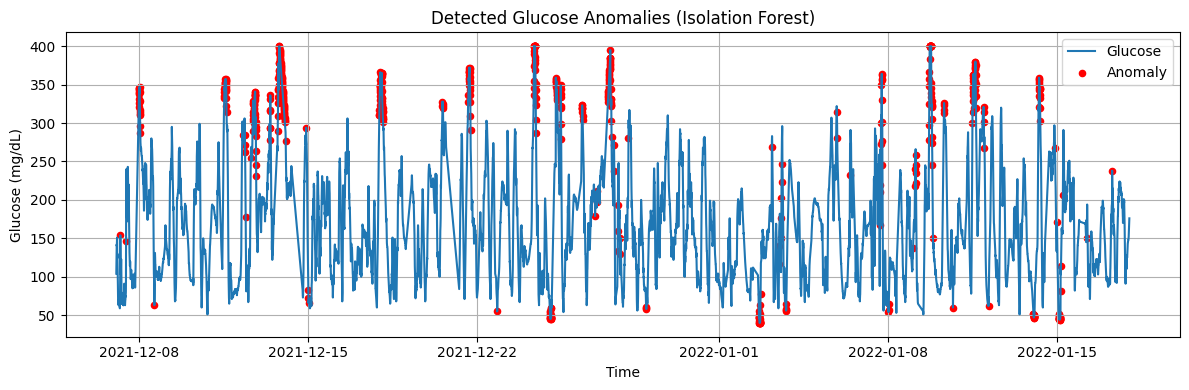

✅ Anomaly-labeled data saved to ../models/559-ws-training_with_anomalies.csv


In [55]:
# Step 2: Load cleaned data
file_path = "../models/559-ws-training_cleaned.csv"
df = pd.read_csv(file_path, parse_dates=['timestamp'], index_col='timestamp')
print("✅ Loaded:", df.shape)
print(df.head())

# Step 3: Select features for anomaly detection
features = [
    'glucose',
    'glucose_change',
    'glucose_rolling_mean',
    'hour',
    'dayofweek'
]

X = df[features].fillna(0)

# Step 4: Train Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_score'] = model.fit_predict(X)
df['anomaly'] = df['anomaly_score'] == -1  # True if outlier

# Step 5: Visualize detected anomalies
plt.figure(figsize=(12, 4))
plt.plot(df['glucose'], label='Glucose')
plt.scatter(df[df['anomaly']].index, df[df['anomaly']]['glucose'], color='red', label='Anomaly', s=20)
plt.title("Detected Glucose Anomalies (Isolation Forest)")
plt.xlabel("Time")
plt.ylabel("Glucose (mg/dL)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Step 6: Save the anomaly-labeled data
output_path = "../models/559-ws-training_with_anomalies.csv"
df.to_csv(output_path)
print(f"✅ Anomaly-labeled data saved to {output_path}")


✅ Loaded: (12079, 8)
✅ RMSE: 22.51
✅ R² Score: 0.90
✅ Model saved to: ../models/glucose_rf_model.pkl


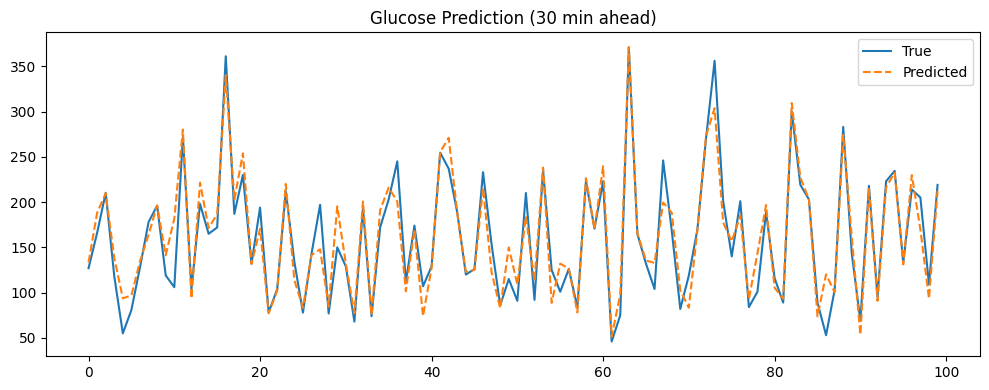

In [58]:
# Step 1: Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os

# Step 2: Load the anomaly-labeled data
df = pd.read_csv("../models/559-ws-training_with_anomalies.csv", parse_dates=["timestamp"], index_col="timestamp")
print("✅ Loaded:", df.shape)

# Step 3: Create prediction target — glucose 30 min ahead
df['glucose_future'] = df['glucose'].shift(-6)  # 6 x 5min = 30min
df = df.dropna()

# Step 4: Define features and target
features = [
    'glucose',
    'glucose_change',
    'glucose_rolling_mean',
    'hour',
    'dayofweek'
]
X = df[features]
y = df['glucose_future']

# Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 7: Predict & evaluate
y_pred = model.predict(X_test)

from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R² Score: {r2:.2f}")

# Step 8: Save model
os.makedirs("../models", exist_ok=True)
joblib.dump(model, "../models/glucose_rf_model.pkl")
print("✅ Model saved to: ../models/glucose_rf_model.pkl")

# Step 9: Plot results
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:100], label="True")
plt.plot(y_pred[:100], label="Predicted", linestyle="--")
plt.title("Glucose Prediction (30 min ahead)")
plt.legend()
plt.tight_layout()
plt.show()
